In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
image = cv2.imread("Images/tableFor3.jpeg")
blur = cv2.GaussianBlur(image, (7, 7), 1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
imgCanny = cv2.Canny(gray,50,50)


In [25]:
_, threshold = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY) 
contours, _ = cv2.findContours( 
    threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 


In [ ]:
def getContours(image, orig):
    contours,hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        print(area)
        if area > 500:
            cv2.drawContours(orig, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            #print(peri)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            print(len(approx))
            objCor = len(approx)
            x, y, w, h = cv2.boundingRect(approx)
            if objCor ==3: 
                objectType ="Tri"
            elif objCor == 4:
                aspRatio = w / float(h)
                if aspRatio > 0.98 and aspRatio < 1.03: objectType= "Square"
                else:objectType = "Rectangle"
            elif objCor > 4: objectType = "Circles"
            else: objectType = "None"

            cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(orig,objectType,
                        (x+(w//2)-10,y+(h//2)-10),cv2.FONT_HERSHEY_COMPLEX,0.7,
                        (0,0,0),2)

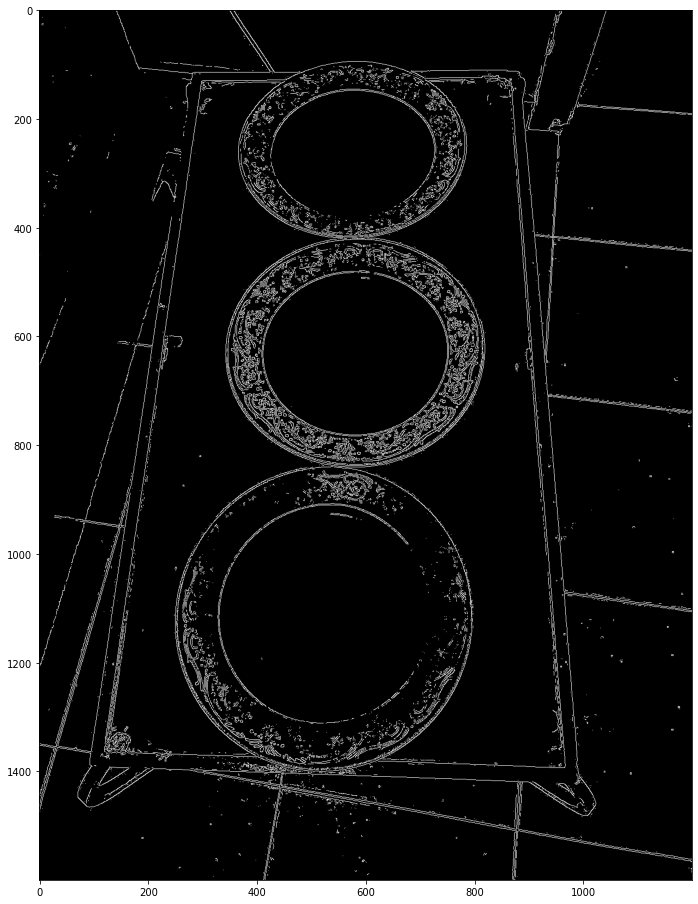

In [33]:
plt.figure(figsize = (12,16))
plt.imshow(imgCanny, cmap='gray', aspect='equal')